## Assignment A3. Pitch and Rhythm

The goal of this assignment is the exploration of classic algorithms (e.g. autocorrelation, DFT-based) to extract fundamental information from musical signals:
- Pitch (in monophonic signals)
- Beats and Tempo;

In [57]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd, sklearn
import librosa, librosa.display
plt.rcParams['figure.figsize'] = (14, 5)

In [58]:
x, sr = librosa.load('Sound_18.wav')
ipd.Audio(x, rate=sr)

In [59]:
print(sr)

22050


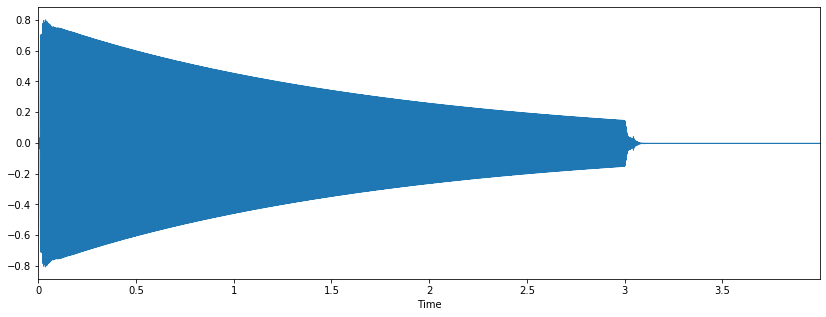

In [60]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr)

In [61]:
hop_length = 256
frame_length = 512

## Spectral centroid

The spectral centroid (Wikipedia) indicates at which frequency the energy of a spectrum is centered upon

In [62]:
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

In [63]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape

(173,)

In [64]:
# time variable for vizualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

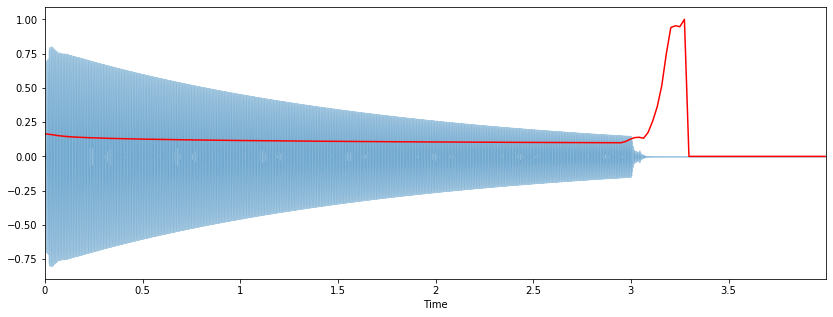

In [65]:
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r') # normalize for visualization purposes


## RMS

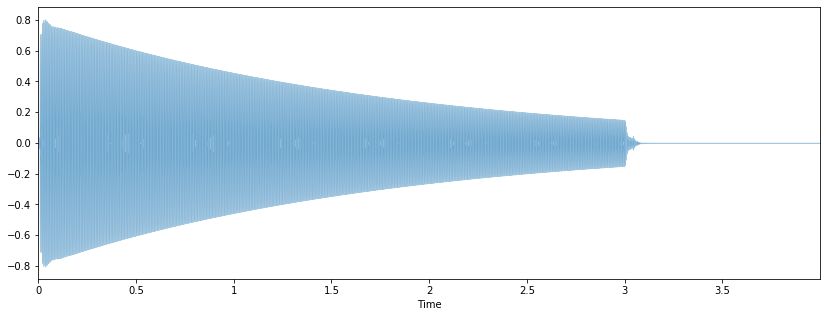

In [66]:
energy = numpy.array([
    sum(abs(x[i:i+frame_length]**2))
    for i in range(0, len(x), hop_length)
])
rmse = librosa.feature.rmse(x, frame_length=frame_length, hop_length=hop_length, center=True)
frames = range(len(energy))
frames2 = range(len(rmse))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
t2 = librosa.frames_to_time(frames2, sr=sr, hop_length=hop_length)
librosa.display.waveplot(x, sr=sr, alpha=0.4)
#plt.plot(t2, , color='r') # normalize for visualization purposes

In [67]:
x2, sr2 = librosa.load('organ.wav')
ipd.Audio(x2, rate=sr2)

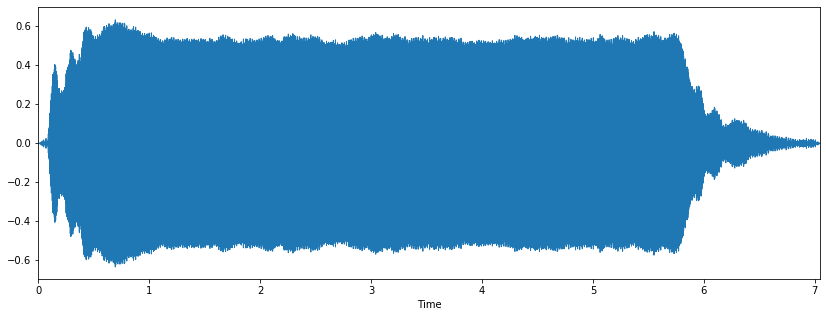

In [68]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x2, sr2)

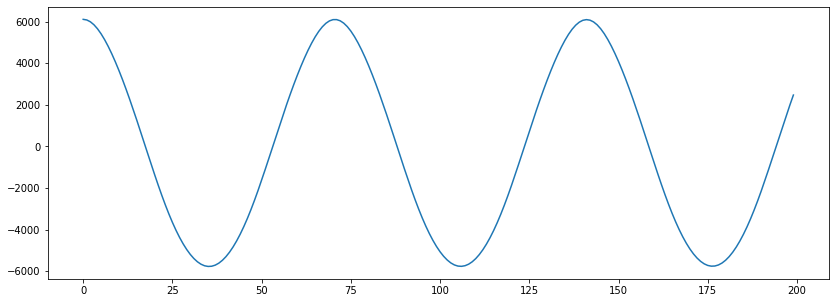

In [69]:
r = librosa.autocorrelate(x, max_size=5000)
plt.figure(figsize=(14, 5))
plt.plot(r[:200])

## Oboe

The autocorrelation always has a maximum at zero, i.e. zero lag. We want to identify the maximum outside of the peak centered at zero. Therefore, we might choose only to search within a range of reasonable pitches:

In [70]:
midi_hi = 120.0
midi_lo = 12.0
f_hi = librosa.midi_to_hz(midi_hi)
f_lo = librosa.midi_to_hz(midi_lo)
t_lo = sr/f_hi
t_hi = sr/f_lo

In [71]:
print(f_lo, f_hi)
print(t_lo, t_hi)

16.351597831287414 8372.018089619156
2.633773573344376 1348.4920695523206


Set invalid pitch candidates to zero:

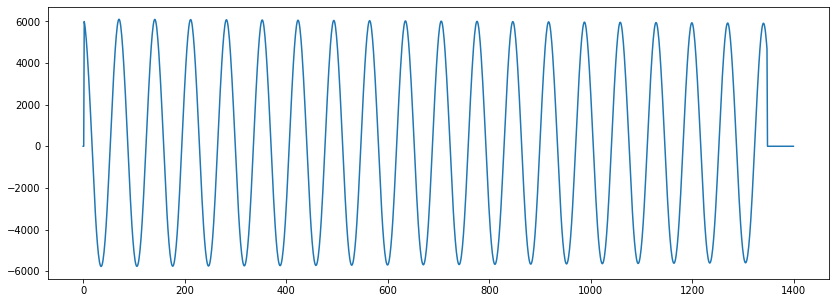

In [72]:
r[:int(t_lo)] = 0
r[int(t_hi):] = 0
plt.figure(figsize=(14, 5))
plt.plot(r[:1400])

Find the location of the maximum:

In [73]:
t_max = r.argmax()
print(t_max)

71


Finally, estimate the pitch in Hertz:

In [74]:
float(sr)/t_max

310.5633802816901

Value coresponds to A4 (69), source: https://musicinformationretrieval.com/midi_conversion_table.html

In [75]:
librosa.midi_to_hz(69)

440.0

## Organ

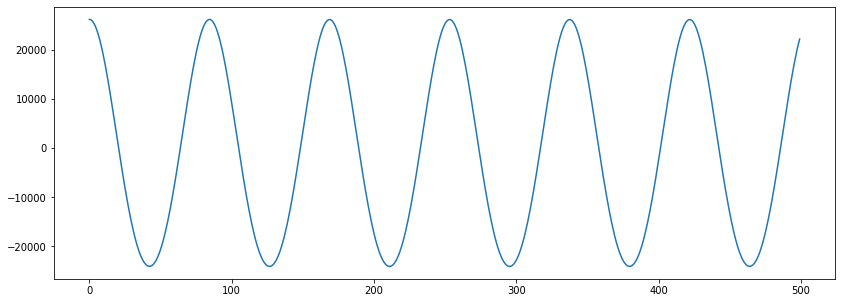

In [76]:
r2 = librosa.autocorrelate(x2, max_size=5000)
plt.figure(figsize=(14, 5))
plt.plot(r2[:500])

In [77]:
print(r2)

[26296.236   26213.191   25964.986   ...  -408.46164 -2242.559
 -4049.1738 ]


In [78]:
midi_hi = 120.0
midi_lo = 12.0
f_hi = librosa.midi_to_hz(midi_hi)
f_lo = librosa.midi_to_hz(midi_lo)
t_lo = sr2/f_hi
t_hi = sr2/f_lo

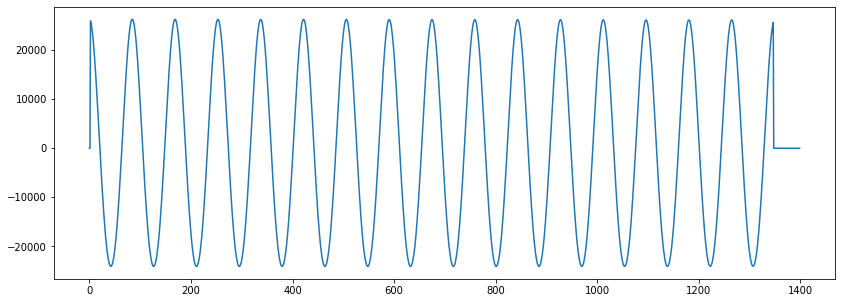

In [79]:
r2[:int(t_lo)] = 0
r2[int(t_hi):] = 0
plt.figure(figsize=(14, 5))
plt.plot(r2[:1400])

In [80]:
t_max2 = r2.argmax()
print(t_max)

71


In [81]:
pitch = float(sr)/t_max2

In [82]:
midi_rep = librosa.hz_to_midi(pitch)

In [83]:
note = librosa.midi_to_note(midi_rep)
print(note)

C4


Value coresponds to C4 (60), source: https://musicinformationretrieval.com/midi_conversion_table.html

In [84]:
librosa.midi_to_hz(60)

261.6255653005986

In [85]:
#Estimate pitch using the autocorrelation method:
def estimate_pitch(segment, sr, fmin=50.0, fmax=2000.0):
    
    # Compute autocorrelation of input segment.
    r = librosa.autocorrelate(segment)
    
    # Define lower and upper limits for the autocorrelation argmax.
    i_min = sr/fmax
    i_max = sr/fmin
    r[:int(i_min)] = 0
    r[int(i_max):] = 0
    
    # Find the location of the maximum autocorrelation.
    i = r.argmax()
    f0 = float(sr)/i
    return f0


In [86]:
estimate_pitch(x,sr) #a4

310.5633802816901

In [87]:
estimate_pitch(x2,sr2) #c4

262.5

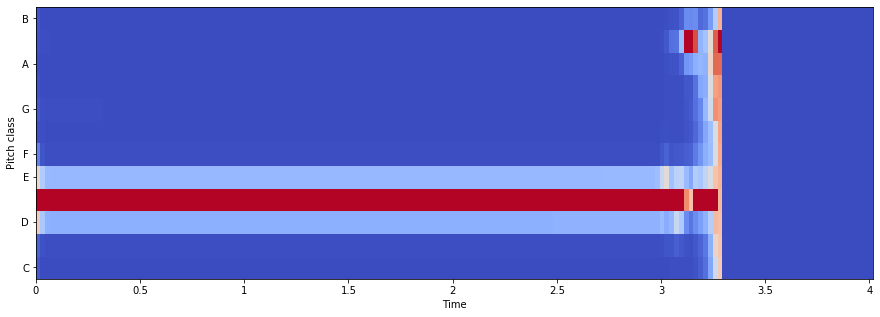

In [88]:
# oboe
hop_length = 512
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')


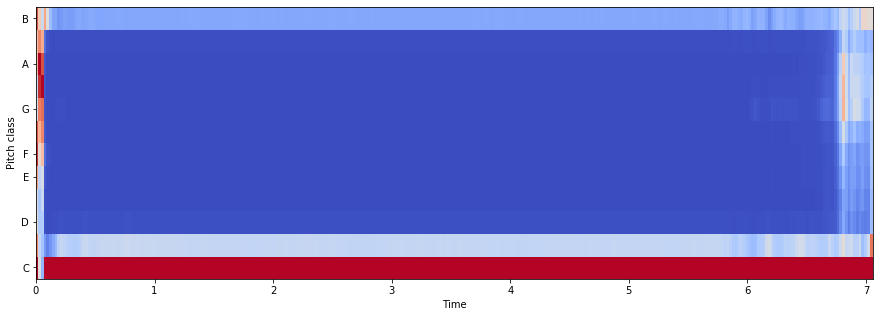

In [89]:
#organ
chromagram = librosa.feature.chroma_stft(x2, sr=sr2, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')


### Is this value correct or incorrect?
To verify the results, we opened to sonic visuliser and we analyzed the files. Here are results:
#### Oboe
![Chromagram of oboe](oboe_chrom.PNG "Oboe")
Chromagram for oboe shows notes A + A# which corresponds with computed notes.

#### Organ
![Chromagram of organ](organ_chrom.PNG "Organ")
Chromagram for oboe shows notes B+C+C# which also corresponds with computed notes.

### Global Analysis
On the previous task, your pitch estimates were frame-based. For the same signals, extend this frame analysis to the full sound, and for each sound:
 1. obtain a plot of the pitch estimation; on the x-axis you’ll have the frame number, on the y-axis the pitch/f0 in Hz.
 2. obtain a plot of the pitch estimation; on the x-axis you’ll have the frame number, on the y-axis the pitch/f0 in MIDI Note (ex. A0, B0, B1)
 3. Is any of these representations ( 1) or 2) ) a chromagram? Explain your answer.

In [90]:
def pitch_detection_in_frames(x, frame_length=2048, hop_length=512):
    frames = librosa.util.frame(x, frame_length=frame_length, hop_length=hop_length); #2048
    total_frames, num_of_values_in_frame = frames.shape;
    pitch_arr_hz = []
    pitch_arr_midi = []
    for i in range(total_frames):
        pitch_max = frames[i].argmax() # counting the pitch for each frame
        if (pitch_max == 0):
            pitch_arr_hz.append(0)
            pitch_arr_midi.append(0)
        else:
            pitch_hz = float(sr)/pitch_max
            pitch_arr_hz.append(pitch_hz) # creating the array with pitches
            midi_rep = librosa.hz_to_midi(pitch_hz)
            pitch_arr_midi.append(midi_rep)

    plt.figure(figsize=(14, 5))
    plt.plot(pitch_arr)
    plt.figure(figsize=(14, 5))
    plt.plot(pitch_arr_midi)

#### Pitch detection for oboe

In [91]:
pitch_detection_in_frames(x) #@todo discuss frame + hop

NameError: name 'pitch_arr' is not defined

<Figure size 1008x360 with 0 Axes>

#### Pitch detection for organ

In [ ]:
pitch_detection_in_frames(x2)

## Task 4 – Pitch and Rhythm II
Hint: You already have most of the code needed for this to work. For a quick fix to obtain the expected result you’ll need to add the following:
- Choose the frames in which you have to estimate the pitch (exclude the silences).
- Choose a way to average the estimates for each note across the different frames.


In [ ]:
x4, sr4 = librosa.load(path+audio_files+'voice.wav')
ipd.Audio(x4, rate=sr4)

In [ ]:
rms = librosa.feature.rms(x4, hop_length=hop_length)[0, :]

plt.plot(rms)

In [ ]:
pip install --upgrade pydub

In [ ]:
# Split the audio signal into non-silent intervals
def split(sound, threshold=50):
    non_silence = librosa.effects.split(sound, threshold)
    list_of_notes = list()
    for k in non_silence:
        # print(k[0], k[1])
        start = k[0]
        end = k[1]+1
        temp_list = list()
        for i in range(start, end):
            temp_list.append(sound[i])
        temp_array = np.array(temp_list)
        list_of_notes.append(temp_array)
    return list_of_notes

notes = split(x4)

In [ ]:
chroma_list = list()
for i in notes:
    chroma_list.append(librosa.feature.chroma_stft(y=i, sr=sr4))

for chroma in chroma_list:
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
    plt.colorbar()
    plt.title('Chromagram')
    plt.tight_layout()
    plt.show()

We can see that the file is splited in 9 sections, exactly like the notes sang by the feminene voice.

In [ ]:
# What would you obtain if you applied the autocorrelation function to this novelty function
rm_auto = librosa.autocorrelate(rms, max_size=5000)
plt.figure(figsize=(14, 5))

plt.plot(rm_auto[:2000])